# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [ ]:
!git clone https://github.com/sim0nsays/dlcourse_ai.git

fatal: destination path 'dlcourse_ai' already exists and is not an empty directory.


In [ ]:
!/content/dlcourse_ai/assignments/assignment1/download_data.sh

In [ ]:
!pip install -r /content/dlcourse_ai/assignments/assignment1/requirements.txt

In [ ]:
!cp /content/dlcourse_ai/assignments/assignment2/* .

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [ ]:
from dataset import load_svhn, random_split_train_val
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [ ]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [ ]:
class ReLULayer:
    def __init__(self):
        pass

    def forward(self, X):
        # TODO: Implement forward pass
        # Hint: you'll need to save some information about X
        # to use it later in the backward pass
        self.X = X
        return np.maximum(self.X, 0)

    def backward(self, d_out):
        """
        Backward pass
        Arguments:
        d_out, np array (batch_size, num_features) - gradient
           of loss function with respect to output
        Returns:
        d_result: np array (batch_size, num_features) - gradient
          with respect to input
        """
        # TODO: Implement backward pass
        # Your final implementation shouldn't have any loops
        r = d_out.copy()
        r[self.X <= 0] = 0
        return r

    def params(self):
        # ReLU Doesn't have any parameters
        return {}


In [ ]:
def check_gradient(f, x, delta=1e-5, tol=1e-4):
    """
    Checks the implementation of analytical gradient by comparing
    it to numerical gradient using two-point formula
    Arguments:
      f: function that receives x and computes value and gradient
      x: np array, initial point where gradient is checked
      delta: step to compute numerical gradient
      tol: tolerance for comparing numerical and analytical gradient
    Return: bool indicating whether gradients match or not
    """

    assert isinstance(x, np.ndarray)
    assert x.dtype == float

    orig_x = x.copy()
    fx, analytic_grad = f(x)
    assert np.all(np.isclose(orig_x, x, tol)), "Functions shouldn't modify input variables"

    assert analytic_grad.shape == x.shape
    analytic_grad = analytic_grad.copy()

    # We will go through every dimension of x and compute numeric derivative for it
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        analytic_grad_at_ix = analytic_grad[ix]

        ix_delta = np.zeros_like(x)
        ix_delta[ix] = delta
        numeric_grad_at_ix = (f(x + ix_delta)[0] - f(x - ix_delta)[0]) / (2 * delta)

        if not np.isclose(numeric_grad_at_ix, analytic_grad_at_ix, tol):
            print("Gradients are different at %s. Analytic: %2.5f, Numeric: %2.5f" % (
            ix, analytic_grad_at_ix, numeric_grad_at_ix))
            return False

        it.iternext()

    print("Gradient check passed!")
    return True


def check_layer_gradient(layer, x, delta=1e-5, tol=1e-4):
    """
    Checks gradient correctness for the input and output of a layer
    Arguments:
      layer: neural network layer, with forward and backward functions
      x: starting point for layer input
      delta: step to compute numerical gradient
      tol: tolerance for comparing numerical and analytical gradient
    Returns:
      bool indicating whether gradients match or not
    """
    output = layer.forward(x)
    output_weight = np.random.randn(*output.shape)

    def helper_func(x):
        output = layer.forward(x)
        loss = np.sum(output * output_weight)
        d_out = np.ones_like(output) * output_weight
        grad = layer.backward(d_out)
        return loss, grad

    return check_gradient(helper_func, x, delta, tol)


def check_layer_param_gradient(layer, x,
                               param_name,
                               delta=1e-5, tol=1e-4):
    """
    Checks gradient correctness for the parameter of the layer
    Arguments:
      layer: neural network layer, with forward and backward functions
      x: starting point for layer input
      param_name: name of the parameter
      delta: step to compute numerical gradient
      tol: tolerance for comparing numerical and analytical gradient
    Returns:
      bool indicating whether gradients match or not
    """
    param = layer.params()[param_name]
    initial_w = param.value

    output = layer.forward(x)
    output_weight = np.random.randn(*output.shape)

    def helper_func(w):
        param.value = w
        output = layer.forward(x)
        loss = np.sum(output * output_weight)
        d_out = np.ones_like(output) * output_weight
        layer.backward(d_out)
        grad = param.grad
        return loss, grad

    return check_gradient(helper_func, initial_w, delta, tol)


def check_model_gradient(model, X, y,
                         delta=1e-5, tol=1e-4):
    """
    Checks gradient correctness for all model parameters
    Arguments:
      model: neural network model with compute_loss_and_gradients
      X: batch of input data
      y: batch of labels
      delta: step to compute numerical gradient
      tol: tolerance for comparing numerical and analytical gradient
    Returns:
      bool indicating whether gradients match or not
    """
    params = model.params()

    for param_key in params:
        print("Checking gradient for %s" % param_key)
        param = params[param_key]
        initial_w = param.value

        def helper_func(w):
            param.value = w
            loss = model.compute_loss_and_gradients(X, y)
            grad = param.grad
            return loss, grad

        if not check_gradient(helper_func, initial_w, delta, tol):
            return False

    return True

In [ ]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [ ]:
def softmax(predictions):
    """
    Computes probabilities from scores
    Arguments:
      predictions, np array, shape is either (N) or (batch_size, N) - classifier output
    Returns:
      probs, np array of the same shape as predictions - probability for every class, 0..1
    """

    if predictions.ndim == 1:
        normalized_predictions = predictions - np.max(predictions)
        return np.exp(normalized_predictions) / np.sum(np.exp(normalized_predictions))
    else:
        normalized_predictions = predictions - np.max(predictions, axis=1)[:, np.newaxis]
        return np.exp(normalized_predictions) / np.sum(np.exp(normalized_predictions), axis=1)[:, np.newaxis]


def cross_entropy_loss(probabilities, target_index):
    """
    Computes cross-entropy loss
    Arguments:
      probabilities, np array, shape is either (N) or (batch_size, N) - probabilities for every class
      target_index: np array of int, shape is (1) or (batch_size) - index of the true class for given sample(s)
    Returns:
      loss: single value
    """
    if probabilities.ndim == 1:
        return -np.log(probabilities[target_index])
    else:
        flatten_target_index = target_index.flatten()
        return -np.mean(np.log(probabilities[(
            np.arange(flatten_target_index.shape[0]),
            flatten_target_index
        )]))


def softmax_with_cross_entropy(predictions, target_index):
    """
    Computes softmax and cross-entropy loss for model predictions,
    including the gradient
    Arguments:
      predictions, np array, shape is either (N) or (batch_size, N) - classifier output
      target_index: np array of int, shape is (1) or (batch_size) - index of the true class for given sample(s)
    Returns:
      loss, single value - cross-entropy loss
      dprediction, np array same shape as predictions - gradient of predictions by loss value
    """
    probabilities = softmax(predictions)
    loss = cross_entropy_loss(probabilities, target_index)

    subtr = np.zeros_like(probabilities)

    if probabilities.ndim == 1:
        subtr[target_index] = 1
        dprediction = probabilities - subtr
    else:
        batch_size = predictions.shape[0]
        subtr[(
            np.arange(target_index.shape[0]),
            target_index.flatten()
        )] = 1
        dprediction = (probabilities - subtr) / batch_size

    return loss, dprediction


def l2_regularization(W, reg_strength):
    """
    Computes L2 regularization loss on weights and its gradient
    Arguments:
      W, np array - weights
      reg_strength - float value
    Returns:
      loss, single value - l2 regularization loss
      gradient, np.array same shape as W - gradient of weight by l2 loss
    """

    loss = reg_strength * (W ** 2).sum()
    gradient = 2 * reg_strength * W

    return loss, gradient


def linear_softmax(X, W, target_index):
    """
    Performs linear classification and returns loss and gradient over W
    Arguments:
      X, np array, shape (num_batch, num_features) - batch of images
      W, np array, shape (num_features, classes) - weights
      target_index, np array, shape (num_batch) - index of target classes
    Returns:
      loss, single value - cross-entropy loss
      gradient, np.array same shape as W - gradient of weight by loss
    """
    predictions = np.dot(X, W)

    loss, dprediction = softmax_with_cross_entropy(predictions, target_index)
    dW = np.dot(X.T, dprediction)

    return loss, dW


class Param:
    """
    Trainable parameter of the model
    Captures both parameter value and the gradient
    """

    def __init__(self, value):
        self.value = value
        self.grad = np.zeros_like(value)


class ReLULayer:
    def __init__(self):
        pass

    def forward(self, X):
        # TODO: Implement forward pass
        # Hint: you'll need to save some information about X
        # to use it later in the backward pass
        self.X = X
        return np.maximum(self.X, 0)

    def backward(self, d_out):
        """
        Backward pass
        Arguments:
        d_out, np array (batch_size, num_features) - gradient
           of loss function with respect to output
        Returns:
        d_result: np array (batch_size, num_features) - gradient
          with respect to input
        """
        # TODO: Implement backward pass
        # Your final implementation shouldn't have any loops
        r = d_out.copy()
        r[self.X <= 0] = 0
        return r

    def params(self):
        # ReLU Doesn't have any parameters
        return {}


class FullyConnectedLayer:
    def __init__(self, n_input, n_output):
        self.W = Param(0.001 * np.random.randn(n_input, n_output))
        self.B = Param(0.001 * np.random.randn(1, n_output))
        self.X = None

    def forward(self, X):
        # TODO: Implement forward pass
        # Your final implementation shouldn't have any loops
        self.X = X
        return self.X.dot(self.W.value) + self.B.value

    def backward(self, d_out):
        """
        Backward pass
        Computes gradient with respect to input and
        accumulates gradients within self.W and self.B
        Arguments:
        d_out, np array (batch_size, n_output) - gradient
           of loss function with respect to output
        Returns:
        d_result: np array (batch_size, n_input) - gradient
          with respect to input
        """
        # TODO: Implement backward pass
        # Compute both gradient with respect to input
        # and gradients with respect to W and B
        # Add gradients of W and B to their `grad` attribute

        # It should be pretty similar to linear classifier from
        # the previous assignment

        self.W.grad += self.X.T.dot(d_out)
        self.B.grad += d_out.sum(axis=0, keepdims=0)

        return d_out.dot(self.W.value.T)

    def params(self):
        return {'W': self.W, 'B': self.B}

In [ ]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [ ]:
class TwoLayerNet:
    """ Neural network with two fully connected layers """

    def __init__(self, n_input, n_output, hidden_layer_size, reg):
        """
        Initializes the neural network
        Arguments:
        n_input, int - dimension of the model input
        n_output, int - number of classes to predict
        hidden_layer_size, int - number of neurons in the hidden layer
        reg, float - L2 regularization strength
        """
        self.reg = reg
        # TODO Create necessary layers
        self.input_layer = FullyConnectedLayer(n_input, hidden_layer_size)
        self.relu = ReLULayer()
        self.output_layer = FullyConnectedLayer(hidden_layer_size, n_output)

        self.W_in = self.input_layer.params()['W']
        self.B_in = self.input_layer.params()['B']

        self.W_out = self.output_layer.params()['W']
        self.B_out = self.output_layer.params()['B']

    def compute_loss_and_gradients(self, X, y):
        """
        Computes total loss and updates parameter gradients
        on a batch of training examples
        Arguments:
        X, np array (batch_size, input_features) - input data
        y, np array of int (batch_size) - classes
        """
        # Before running forward and backward pass through the model,
        # clear parameter gradients aggregated from the previous pass
        # TODO Set parameter gradient to zeros
        # Hint: using self.params() might be useful!
        for p in self.params().values():
            p.grad.fill(0)

        # TODO Compute loss and fill param gradients
        # by running forward and backward passes through the model

        forward_input_layer = self.input_layer.forward(X)
        forward_relu = self.relu.forward(forward_input_layer)
        predictions = self.output_layer.forward(forward_relu)

        loss, dprediction = softmax_with_cross_entropy(predictions, y)

        backward_output_layer = self.output_layer.backward(dprediction)
        backward_relu = self.relu.backward(backward_output_layer)
        backward_input_layer = self.input_layer.backward(backward_relu)

        # After that, implement l2 regularization on all params
        # Hint: self.params() is useful again!

        for p in self.params().values():
            loss_l2, grad_l2 = l2_regularization(p.value, self.reg)
            loss += loss_l2
            p.grad += grad_l2

        return loss

    def predict(self, X):
        """
        Produces classifier predictions on the set
        Arguments:
          X, np array (test_samples, num_features)
        Returns:
          y_pred, np.array of int (test_samples)
        """
        # TODO: Implement predict
        # Hint: some of the code of the compute_loss_and_gradients
        # can be reused

        forward_input_layer = self.input_layer.forward(X)
        forward_relu = self.relu.forward(forward_input_layer)
        predictions = self.output_layer.forward(forward_relu)

        return np.argmax(predictions, axis=-1)

    def params(self):
        # TODO Implement aggregating all of the params

        return {
            'W_in': self.W_in,
            'B_in': self.B_in,
            'W_out': self.W_out,
            'B_out': self.B_out,
        }

In [ ]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W_in
Gradient check passed!
Checking gradient for B_in
Gradient check passed!
Checking gradient for W_out
Gradient check passed!
Checking gradient for B_out
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [ ]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W_in
Gradient check passed!
Checking gradient for B_in
Gradient check passed!
Checking gradient for W_out
Gradient check passed!
Checking gradient for B_out
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [ ]:
def multiclass_accuracy(prediction, ground_truth):
    """
    Computes metrics for multiclass classification
    Arguments:
    prediction, np array of int (num_samples) - model predictions
    ground_truth, np array of int (num_samples) - true labels
    Returns:
    accuracy - ratio of accurate predictions to total samples
    """

    # TODO: Implement computing accuracy

    return sum(np.equal(prediction, ground_truth)) / len(ground_truth)

In [ ]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.13333333333333333

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [ ]:
from copy import deepcopy


class Dataset:
    """
    Utility class to hold training and validation data
    """

    def __init__(self, train_X, train_y, val_X, val_y):
        self.train_X = train_X
        self.train_y = train_y
        self.val_X = val_X
        self.val_y = val_y


class Trainer:
    """
    Trainer of the neural network models
    Perform mini-batch SGD with the specified data, model,
    training parameters and optimization rule
    """

    def __init__(self, model, dataset, optim,
                 num_epochs=20,
                 batch_size=20,
                 learning_rate=1e-2,
                 learning_rate_decay=1.0):
        """
        Initializes the trainer
        Arguments:
        model - neural network model
        dataset, instance of Dataset class - data to train on
        optim - optimization method (see optim.py)
        num_epochs, int - number of epochs to train
        batch_size, int - batch size
        learning_rate, float - initial learning rate
        learning_rate_decal, float - ratio for decaying learning rate
           every epoch
        """
        self.dataset = dataset
        self.model = model
        self.optim = optim
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.learning_rate_decay = learning_rate_decay

        self.optimizers = None

    def setup_optimizers(self):
        params = self.model.params()
        self.optimizers = {}
        for param_name, param in params.items():
            self.optimizers[param_name] = deepcopy(self.optim)

    def compute_accuracy(self, X, y):
        """
        Computes accuracy on provided data using mini-batches
        """
        indices = np.arange(X.shape[0])
        sections = np.arange(self.batch_size, X.shape[0], self.batch_size)
        batches_indices = np.array_split(indices, sections)

        pred = np.zeros_like(y)

        for batch_indices in batches_indices:
            batch_X = X[batch_indices]
            pred_batch = self.model.predict(batch_X)
            pred[batch_indices] = pred_batch

        return multiclass_accuracy(pred, y)

    def fit(self):
        """
        Trains a model
        """
        if self.optimizers is None:
            self.setup_optimizers()

        num_train = self.dataset.train_X.shape[0]

        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for epoch in range(self.num_epochs):
            shuffled_indices = np.arange(num_train)
            np.random.shuffle(shuffled_indices)
            sections = np.arange(self.batch_size, num_train, self.batch_size)
            batches_indices = np.array_split(shuffled_indices, sections)

            batch_losses = []

            for batch_indices in batches_indices:
                # TODO Generate batches based on batch_indices and
                # use model to generate loss and gradients for all
                # the params

                batch_X = self.dataset.train_X[batch_indices]
                batch_y = self.dataset.train_y[batch_indices]

                loss = self.model.compute_loss_and_gradients(batch_X, batch_y)

                for param_name, param in self.model.params().items():
                    optimizer = self.optimizers[param_name]
                    param.value = optimizer.update(param.value, param.grad, self.learning_rate)

                batch_losses.append(loss)

            # TODO: Implement learning rate decay
            self.learning_rate *= self.learning_rate_decay

            ave_loss = np.mean(batch_losses)

            train_accuracy = self.compute_accuracy(self.dataset.train_X, self.dataset.train_y)

            val_accuracy = self.compute_accuracy(self.dataset.val_X, self.dataset.val_y)

            print(f'Epoch: {epoch}, '
                  f'loss: {"{:.6f}".format(batch_losses[-1])}, '
                  f'train accuracy: {"{:.6f}".format(train_accuracy)}, '
                  f'val accuracy: {"{:.6f}".format(val_accuracy)}'
                  )

            loss_history.append(ave_loss)
            train_acc_history.append(train_accuracy)
            val_acc_history.append(val_accuracy)

        return loss_history, train_acc_history, val_acc_history

In [128]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-3)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Epoch: 0, loss: 2.302670, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 1, loss: 2.302285, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 2, loss: 2.302305, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 3, loss: 2.302563, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 4, loss: 2.302657, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 5, loss: 2.301966, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 6, loss: 2.302380, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 7, loss: 2.301363, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 8, loss: 2.301778, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 9, loss: 2.301804, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 10, loss: 2.302130, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 11, loss: 2.302631, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 12, loss: 2.302528, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 13, loss: 2.302

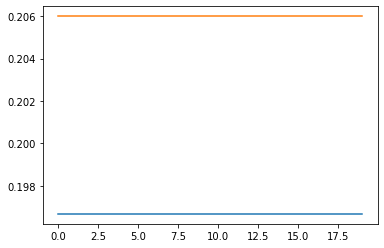

In [129]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [130]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Epoch: 0, loss: 2.295309, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 1, loss: 2.254612, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 2, loss: 2.315275, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 3, loss: 2.274441, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 4, loss: 2.259460, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 5, loss: 2.287047, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 6, loss: 2.196892, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 7, loss: 2.267013, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 8, loss: 2.323265, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 9, loss: 2.328419, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 10, loss: 2.352009, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 11, loss: 2.092648, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 12, loss: 2.291146, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 13, loss: 2.250

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [131]:
class MomentumSGD:
    """
    Implements Momentum SGD update
    """
    def __init__(self, momentum=0.9):
        self.momentum = momentum
        self.velocity = 0
    
    def update(self, w, d_w, learning_rate):
        """
        Performs Momentum SGD update
        Arguments:
        w, np array - weights
        d_w, np array, same shape as w - gradient
        learning_rate, float - learning rate
        Returns:
        updated_weights, np array same shape as w
        """
        # TODO Implement momentum update
        # Hint: you'll need to introduce some variables to remember
        # velocity from the previous updates

        self.velocity = self.momentum * self.velocity - d_w * learning_rate

        return w + self.velocity

In [132]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Epoch: 0, loss: 2.322207, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 1, loss: 2.305562, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 2, loss: 2.312147, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 3, loss: 2.281875, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 4, loss: 2.287471, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 5, loss: 2.291925, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 6, loss: 2.295284, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 7, loss: 2.282446, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 8, loss: 2.330917, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 9, loss: 2.298601, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 10, loss: 2.282478, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 11, loss: 2.271572, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 12, loss: 2.284701, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 13, loss: 2.303

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [133]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Epoch: 0, loss: 2.335821, train accuracy: 0.200000, val accuracy: 0.066667
Epoch: 1, loss: 2.336464, train accuracy: 0.200000, val accuracy: 0.066667
Epoch: 2, loss: 2.295228, train accuracy: 0.333333, val accuracy: 0.066667
Epoch: 3, loss: 2.279056, train accuracy: 0.200000, val accuracy: 0.066667
Epoch: 4, loss: 2.285170, train accuracy: 0.266667, val accuracy: 0.000000
Epoch: 5, loss: 2.263880, train accuracy: 0.266667, val accuracy: 0.000000
Epoch: 6, loss: 2.231426, train accuracy: 0.266667, val accuracy: 0.000000
Epoch: 7, loss: 2.278779, train accuracy: 0.266667, val accuracy: 0.000000
Epoch: 8, loss: 2.282354, train accuracy: 0.400000, val accuracy: 0.000000
Epoch: 9, loss: 2.246044, train accuracy: 0.400000, val accuracy: 0.000000
Epoch: 10, loss: 2.084230, train accuracy: 0.400000, val accuracy: 0.000000
Epoch: 11, loss: 2.021328, train accuracy: 0.400000, val accuracy: 0.000000
Epoch: 12, loss: 1.981028, train accuracy: 0.333333, val accuracy: 0.000000
Epoch: 13, loss: 2.370

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [134]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 400, reg = 1e-3)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=20, batch_size=2)

loss_history, train_history, val_history = trainer.fit()

Epoch: 0, loss: 2.320141, train accuracy: 0.266667, val accuracy: 0.066667
Epoch: 1, loss: 2.216322, train accuracy: 0.200000, val accuracy: 0.066667
Epoch: 2, loss: 2.445361, train accuracy: 0.333333, val accuracy: 0.066667
Epoch: 3, loss: 2.343844, train accuracy: 0.400000, val accuracy: 0.000000
Epoch: 4, loss: 2.197360, train accuracy: 0.333333, val accuracy: 0.133333
Epoch: 5, loss: 2.140217, train accuracy: 0.400000, val accuracy: 0.000000
Epoch: 6, loss: 1.558163, train accuracy: 0.533333, val accuracy: 0.133333
Epoch: 7, loss: 2.377700, train accuracy: 0.600000, val accuracy: 0.000000
Epoch: 8, loss: 1.798986, train accuracy: 0.600000, val accuracy: 0.133333
Epoch: 9, loss: 0.139595, train accuracy: 0.533333, val accuracy: 0.066667
Epoch: 10, loss: 0.093301, train accuracy: 0.733333, val accuracy: 0.000000
Epoch: 11, loss: 0.083112, train accuracy: 0.800000, val accuracy: 0.000000
Epoch: 12, loss: 0.031759, train accuracy: 0.800000, val accuracy: 0.133333
Epoch: 13, loss: 0.018

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [135]:
# Let's train the best one-hidden-layer network we can
from itertools import product


learning_rates = [1e-1, 1e-2]
reg_strength = [1e-3]
learning_rate_decay = [0.9]
hidden_layer_size = [256, 512]
num_epochs = 20
batch_size = [256]

best_classifier = None
best_val_accuracy = 0

loss_history = []
train_history = []
val_history = []

dataset = Dataset(train_X, train_y, val_X, val_y)

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

learning_suites = [
    learning_rates,
    reg_strength,
    learning_rate_decay,
    hidden_layer_size,
    batch_size
]

best_learning_suite = None

for lr, rs, lrd, hls, bs in product(*learning_suites):
    model = TwoLayerNet(n_input=train_X.shape[1],
                        n_output=10,
                        hidden_layer_size=hls,
                        reg=rs
                        )
    trainer = Trainer(model, dataset, MomentumSGD(),
                      learning_rate=lr,
                      learning_rate_decay=lrd,
                      num_epochs=num_epochs,
                      batch_size=bs
                      )
    ls_loss_history, ls_train_history, ls_val_history = trainer.fit()

    if ls_val_history[-1] > best_val_accuracy:
        best_classifier = model
        best_val_accuracy = ls_val_history[-1]
        best_learning_suite = [(lr, rs, lrd, hls, bs)]
        loss_history = ls_loss_history.copy()
        train_history = ls_train_history.copy()
        val_history = ls_val_history.copy()

    for best_lr, best_rs, best_lrd, best_hls, best_bs in best_learning_suite:
        print(f'Best learning suite: '
              f'best learning rate: {best_lr} '
              f'best regularization strength: {best_rs} '
              f'best learning rate decay: {best_lrd} '
              f'best hidden layer size: {best_hls} '
              f'best batch size: {best_bs} '
              )
    print(f'Best validation accuracy: {best_val_accuracy}')

print(f'Best validation accuracy achieved: {best_val_accuracy}')

Epoch: 0, loss: 2.226307, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 1, loss: 2.031843, train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 2, loss: 1.907048, train accuracy: 0.313889, val accuracy: 0.322000
Epoch: 3, loss: 1.802091, train accuracy: 0.432667, val accuracy: 0.438000
Epoch: 4, loss: 1.551115, train accuracy: 0.535111, val accuracy: 0.533000
Epoch: 5, loss: 1.690280, train accuracy: 0.606889, val accuracy: 0.594000
Epoch: 6, loss: 1.192438, train accuracy: 0.655111, val accuracy: 0.643000
Epoch: 7, loss: 1.082381, train accuracy: 0.661333, val accuracy: 0.631000
Epoch: 8, loss: 1.217155, train accuracy: 0.700556, val accuracy: 0.671000
Epoch: 9, loss: 1.060865, train accuracy: 0.704000, val accuracy: 0.664000
Epoch: 10, loss: 0.890894, train accuracy: 0.716667, val accuracy: 0.681000
Epoch: 11, loss: 1.202148, train accuracy: 0.727778, val accuracy: 0.691000
Epoch: 12, loss: 1.151817, train accuracy: 0.746444, val accuracy: 0.712000
Epoch: 13, loss: 0.979

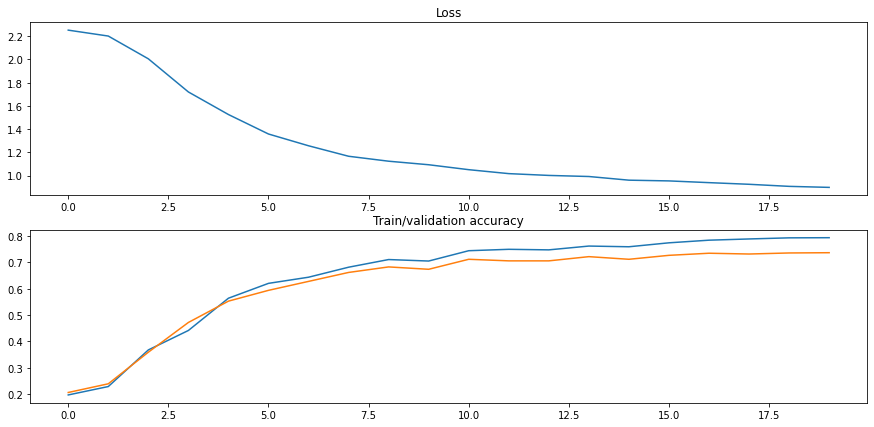

In [136]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [137]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.707000
